# **Trensfer learning with TensorFlow Part 1: Feature Extraction**

**Transfer learning** is leveraging a working model's existing architecture and learned patterns for our own problems.

There are two main benefits:
1. Can leverage an existing neural network archtecture proven to work on problems similar to our own.
2. Can leverage a working neural network archtecture which has already learned patterns on similar data to our own, then we can adapt those patterns to our own data.

### **Downloading and becoming one with the data**

In [2]:
# Get the data (10% of 10 food classes from Food101)

# Unzip the downloaded file
import zipfile
zip_ref = zipfile.ZipFile('data/10_food_classes_10_percent.zip')
zip_ref.extractall('data')
zip_ref.close()

import shutil
shutil.rmtree('data/__MACOSX')

In [3]:
# How many images in each folder?
import os

# Walk through 10 percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk('data/10_food_classes_10_percent'):
    print(f'There are {len(dirnames)} directories and {len(filenames)} images in "{dirpath}".')

There are 2 directories and 0 images in "data/10_food_classes_10_percent".
There are 10 directories and 0 images in "data/10_food_classes_10_percent\test".
There are 0 directories and 250 images in "data/10_food_classes_10_percent\test\chicken_curry".
There are 0 directories and 250 images in "data/10_food_classes_10_percent\test\chicken_wings".
There are 0 directories and 250 images in "data/10_food_classes_10_percent\test\fried_rice".
There are 0 directories and 250 images in "data/10_food_classes_10_percent\test\grilled_salmon".
There are 0 directories and 250 images in "data/10_food_classes_10_percent\test\hamburger".
There are 0 directories and 250 images in "data/10_food_classes_10_percent\test\ice_cream".
There are 0 directories and 250 images in "data/10_food_classes_10_percent\test\pizza".
There are 0 directories and 250 images in "data/10_food_classes_10_percent\test\ramen".
There are 0 directories and 250 images in "data/10_food_classes_10_percent\test\steak".
There are 0 di

### **Creating data loaders (preparing the data)**

We'll use `ImageDataGenerator` class to load images into batches.

In [4]:
import tensorflow as tf

# Setup global hyperparameters
IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

# Setup data directories
train_dir = 'data/10_food_classes_10_percent/train/'
test_dir = 'data/10_food_classes_10_percent/test/'

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255.)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255.)

print('Train data:')
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size=IMAGE_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode='categorical')

print('Test data:')
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=IMAGE_SHAPE,
                                             batch_size=BATCH_SIZE,
                                             class_mode='categorical')

Train data:
Found 750 images belonging to 10 classes.
Test data:
Found 2500 images belonging to 10 classes.


### **Setting up callbacks**

**Callbacks** are extra functionality you can add to your models to be performed during or after training. 

Some of the most popular callbacks:
* Tracking experiments with **TensorBoard** callback
* Model checkpoint with **ModelCheckpoint** callback
* Stopping a model from training before it trains too long with **EarlyStopping** callback

| **Callback Name** | **Use case** | **Code**
| :------------: | :-------:  | :-------:  |
| **TensorBoard** | Log the performance of multiple models and then view and compare <br> these models in a visual way on TensorBoard (a dashboard for <br> inspecting neural network parameters). Helpful to compare the results <br> of different models on your data. | tf.keras.callbacks.TensorBoard()
| **Model checkpointing** | Save your model as it trains so you can stop training if needed and <br> come back to confinue off where you left. Helpful if training takes a <br> long time and can't be done in one sitting. | tf.keras.callbacks.ModelCheckpoint()
| **Early stopping** | Leave your model train for an arbitrary amount of time and have it <br> stop training automatically when it ceases to improve. Helpful when you've got a large dataset and don't know how long training will take. | tf.keras.callbacks.EarlyStopping()

In [5]:
# Let's make a function creating a TensorBoard
def create_tensorboad_callback(dir_name, experiment_name):
    '''
    Creates a TensorBoard callback.

    Args:
        dir_name (str): A directory where TensorBoard output will be saved.
        experiment_name (str): name of the experiment.

    Returns:
        TensorBoard callback stored in a dir_name directory.
    '''
    import datetime
    import tensorflow as tf

    # Create a log directory
    log_dir = dir_name + '/' + experiment_name + '/' + datetime.datetime.now().strftime('%Y-%m-%d_%H:%M:%S')

    # Set the TensorBoard callback
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

    # Print output
    print(f'Saving TensorBoad log files to {log_dir}')

    return tensorboard_callback

### **Creating models using TensorFlow Hub**

In the past we've used TensorFlow to create our own modles layer by layer from scratch.

Now we're going to do a similar process, except the majority of our model's layers are going to come from TensorFlow Hub.

We can access pretrained model on: https://tfhub.dev.

Browsing the TensorFlow Hub page and sorting for image classification, we found the following feature vector model link: https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1.

In [6]:
# Let's compare the following two models
resnet_url = 'https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5'
efficientnet_url = 'https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1'

In [7]:
# Let's make a create_model function to create model from a URL
def create_model(model_url, trainable=False, layer_name='feature_extraction_layer', 
                 image_shape=(224, 224), num_classes=10, clasification_type='multiclass'):
    '''
    Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.

    Args:
        model_url (str): A TensorFlow Hub feature extraction URL.
        trainable (bool): Do you want to reset already learned features?
            Default False.
        layer_name (str): name of the feature_extractor layer.
        image_shape (int, int): shape of the image (height, width)
        classification_type (str): "multiclass" for multiclass classification,
            "binary" for binary classification
        num_classes (int): Number of output neurons in the output layer,
            should be equal to number of target classes, default 10.

    Returns:
        An uncompiled Keras Sequential model with model_url as feature extractor
        layer and Dense output layer with num_classes output neurons.
    '''
    import tensorflow as tf
    import tensorflow_hub as hub

    # Download the pretrained model and save it as a Keras layer
    feature_extractor_layer = hub.KerasLayer(model_url,
                                             trainable=trainable, # freeze the already learned patterns
                                             name=layer_name, 
                                             input_shape=image_shape+(3,)) 

    # Set output layer activation function based on clasification_type:
    if clasification_type == 'multiclass': 
        activation_function = 'softmax' 
    elif clasification_type == 'binary':
        activation_function = 'sigmoid' 
    else:
        raise ValueError('clasification_function must be "multiclass" or "binary"')

    # Create a model
    model = tf.keras.models.Sequential([
        feature_extractor_layer,
        tf.keras.layers.Dense(num_classes, activation=activation_function)
    ])

    return model

### **Creating and testing ResNet TensorFlow Hub Feature Extraction model**

In [24]:
import functions

In [13]:
# Create a ResNet model
resnet_model = functions.create_model(resnet_url,
                                      num_classes=train_data_10_percent.num_classes)

In [14]:
# Compile a ResNet model
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

In [15]:
# Fit a ResNet model
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  callbacks=[functions.create_tensorboad_callback(dir_name='tensorflow_hub',
                                                                                  experiment_name='resnet_V2_50')])

Saving TensorBoad log files to tensorflow_hub/resnet_V2_50/2022-10-30_18-29-59
Epoch 1/5
24/24 [==============================] - 228s 10s/step - loss: 1.9186 - accuracy: 0.3467 - val_loss: 1.1704 - val_accuracy: 0.6460
Epoch 2/5
24/24 [==============================] - 216s 9s/step - loss: 0.8933 - accuracy: 0.7467 - val_loss: 0.8283 - val_accuracy: 0.7404
Epoch 3/5
24/24 [==============================] - 216s 9s/step - loss: 0.6024 - accuracy: 0.8347 - val_loss: 0.7383 - val_accuracy: 0.7684
Epoch 4/5
24/24 [==============================] - 204s 9s/step - loss: 0.4587 - accuracy: 0.8827 - val_loss: 0.7063 - val_accuracy: 0.7724
Epoch 5/5
24/24 [==============================] - 192s 8s/step - loss: 0.3770 - accuracy: 0.9053 - val_loss: 0.6773 - val_accuracy: 0.7792


Transfer learning feature extractor model substantially outperformed all of the previous models we've built by hand, what is more it had only 10% of the data to learn from.

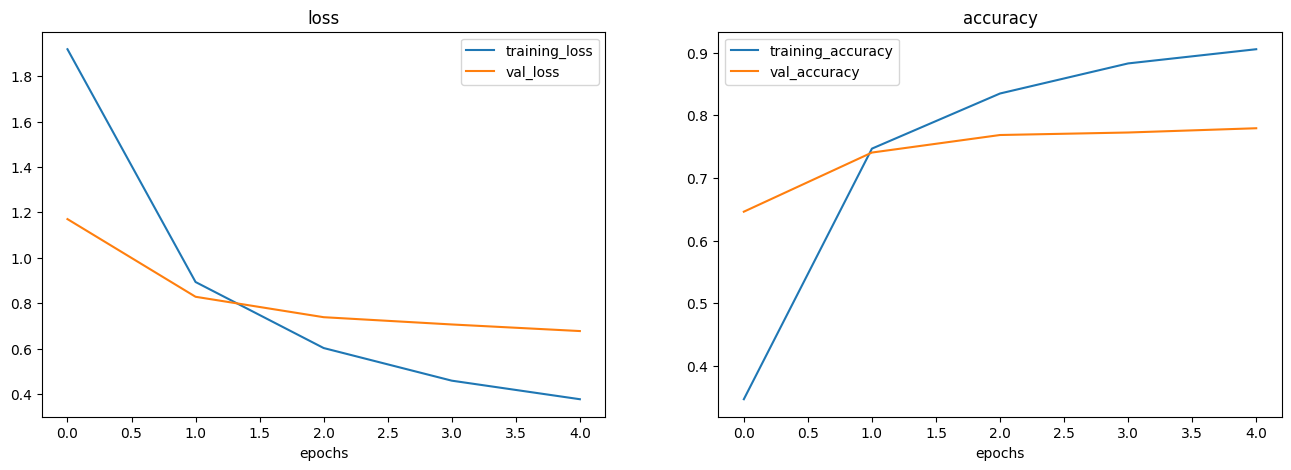

In [23]:
# Let's plot loss curves
functions.plot_loss_curves(resnet_history, metric_name='accuracy')

### **Creating and testing EfficientNet TensorFlow Hub Feature Extraction model**

**Details on EfficientNet:** https://ai.googleblog.com/2019/05/efficientnet-improving-accuracy-and.html

In [ ]:
import functions
import importlib
importlib.reload(functions)

In [26]:
# Create and compile a EfficientNet model
efficientnet_model = functions.create_model(model_url=efficientnet_url,
                                            num_classes=train_data_10_percent.num_classes)

# Compile EfficientNet model
efficientnet_model.compile(loss='binary_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])

In [27]:
efficientnet_history = efficientnet_model.fit(train_data_10_percent,
                                              epochs=5,
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data=test_data,
                                              validation_steps=len(test_data),
                                              callbacks=[functions.create_tensorboad_callback(dir_name='tensorflow_hub',
                                                                                              experiment_name='efficientnet_B0')])

Saving TensorBoad log files to tensorflow_hub/efficientnet_B0/2022-10-30_19-09-40
Epoch 1/5
24/24 [==============================] - 138s 5s/step - loss: 0.4219 - accuracy: 0.2720 - val_loss: 0.2862 - val_accuracy: 0.5360
Epoch 2/5
24/24 [==============================] - 111s 5s/step - loss: 0.2536 - accuracy: 0.6773 - val_loss: 0.2230 - val_accuracy: 0.7508
Epoch 3/5
24/24 [==============================] - 129s 6s/step - loss: 0.2021 - accuracy: 0.7907 - val_loss: 0.1852 - val_accuracy: 0.8120
Epoch 4/5
24/24 [==============================] - 120s 5s/step - loss: 0.1717 - accuracy: 0.8253 - val_loss: 0.1632 - val_accuracy: 0.8356
Epoch 5/5
24/24 [==============================] - 127s 5s/step - loss: 0.1514 - accuracy: 0.8573 - val_loss: 0.1480 - val_accuracy: 0.8484


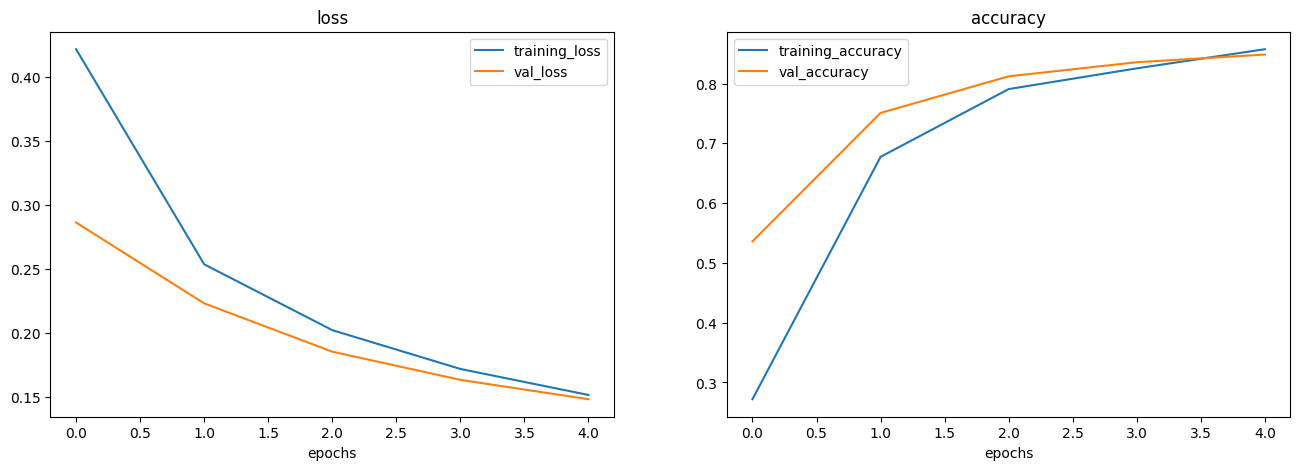

In [29]:
# Let's plot loss curves
functions.plot_loss_curves(efficientnet_history, metric_name='accuracy')

### **Compare number of parameters in  ResNet and EfficientNet**

In [30]:
resnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 dense_1 (Dense)             (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [31]:
efficientnet_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 dense_3 (Dense)             (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [35]:
# How many layers does EfficientNetB0 feature extractor have?
len(efficientnet_model.layers[0].weights) # approximately

309

### **Different types of transfer learning**

* **"As is" transfer learning** - using an existing model with no changes whatsoever (e.g. using ImageNet on 1000 ImageNet classes, none of your own).
* **"Feature extraction" transfer learning** - use the prelearned patterns of an existing model (e.g. EfficientNetB0 trained on ImageNet) and adjust the output layer for your own problem (e.g. 1000 classes -> 10 classes of food).
* **"Fine-tuning" transfer learning** - use the prelearned patterns of an existing model and "fine-tune" many or all of the underlying layers (including new output layers).

### **Comparing models results using TensorBoard**

🔑 **Note:** When you upload things to TensorBoard.dev, your exepriments are public. So if you're running private experiments (things you don't want others to see) do not upload them to TensorBoard.dev.

In [ ]:
# Start TensorBoard session
# 1. Open the command palette (Ctrl/Cmd + Shift + P)
# 2. Search for the command “Python: Launch TensorBoard” and press enter.
# 3. You will be able to select the folder where your TensorBoard log files are located. 
#    By default, the current working directory will be used.

import tensorboard